# specage Example: Peak Fitting
This example demonstrates how to use the pkfit module of specage. The data used are spectra recorded by OceanOptics HR2000+ spectrometer. matplotlib and numpy are needed. The peak fitting module currently supports gaussian and lorentzian peak shapes as well as linear baselines. If needed additional functions can be easily implemented individually or upon request.


## Step 0: Preamble

Import the necessary modules, to create a working environment:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

From specage the specific reader function is needed as well as the peakfit module:

In [2]:
from specage.ov_readers import spectra_time_series as read_ts
import specage.pkfit as pkfit

## Step 1: Load & Inspect the Data

First, read ASCII data by using the reader for OceanOptics Spectra and create the TimeSeries Object *ts*

In [3]:
Filepath = './/example_data//'
Filename = 'examplesTS.txt'

ts = read_ts(Filepath+Filename);

*ts* contains all spectra and their recording times as Spectrum objects. 

Now, we inspect the full data set: 

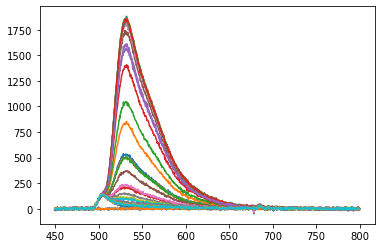

In [4]:
plt.plot(ts.x, ts.intarray);

Select and plot a specific spectrum (*AniceSpectrum*):

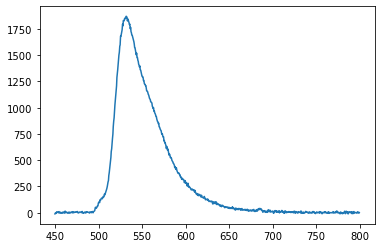

In [5]:
AniceSpectrum = ts[29]

plt.plot(AniceSpectrum.x, AniceSpectrum.intensity);

## Step 2: Peak fitting

First, some input parameters mus be defined, starting with the model which is defined by a list of functions that are provided in pkfit. The model can contain any number of individual functions. Furthermor the x-range is defined:

In [6]:
model = [
         pkfit.lin,             # a linear baseline
         pkfit.gaussarea,       # a gaussian peak with the area as parameter
         pkfit.lorentzarea,     # a lorentzian peak with the area as parameter
         ]
xrange = np.array([503,680])

The linear baseline function pkfit.lin has 2 parameters: 
1. y-intercept 
2. slope.

The peakfunctions have 3 parameters: 
1. size (peak height(amplitude) or area)
2. x-position 
3. width

These informations are important for model creation can be found in the doc of each function. *help(function)*

For fitting initial starting values must be defined for all parameters in a numpy array of of length \[n,\], with n being the sum of the number of all 
parameters. For example for the model defined above n = 8. The position of each parameter is defined by the position of the function in the model list and the order of the parameters accepted by the functions:

In [7]:
initpara = np.array([ 
                     0.0 , 0.0,        # y-intercept, slope,       --> pkfit.lin
                     1500, 530, 10,    # height1, x-pos1, width1,  --> pkfit.gaussarea
                     500 , 565, 10,    # height2, x-pos2, width2,  --> pkfit.lorentzarea
                     ])

Next, it is defined which parameters are fitting parameters (*True*) or fixed (*False*) during fitting. The order and shape of the numpy array is the same as for starting values:

In [8]:
fitparbool = np.bool_([
                       1,0,    # y-intercept, slope,
                       1,1,1,  # height1, x-pos1, width1,
                       1,1,1,  # height2, x-pos2, width2,
                       ])

Finally, lower (lb) and upper boundary are defined in the same way. If no boundaries are wanted, use *np.inf* or *-np.inf*.

NB: Even if one ore more specific parameters are fixed (and hence will be ignored by the peakfit module) a value for the boundary must be defined, to keep the structure and to avoid confusions.

In [9]:
lowerbound = np.array([ 
                       -np.inf, -np.inf,             # y-intercept, slope,
                           0.0,     500, 5,          # height1, x-pos1, width1,
                           0.0,     540, 5,          # height2, x-pos2, width2,
                        ])
upperbound = np.array([
                             0, np.inf,          # y-intercept, slope,
                        np.inf,    550, 100,     # height1, x-pos1, width1,
                        np.inf,    590, 100,     # height2, x-pos2, width2,
                        ])

Now, the fitpeak function is called to fit the peak and all the parameters defined above are passed. The console output can be controlled by the 'verbose' keyword argument. verbose = 2 shows all progress and indicates the success of the fitting routine.

In [10]:
pkfit.fitpeak(AniceSpectrum, 
                initpara, 
                fitparbool, 
                model, 
                xrange = xrange,
                lb=lowerbound, 
                ub=upperbound,
                verbose=2,
                )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1969e+08                                    1.34e+06    
       1              2         1.1245e+08      7.25e+06       1.59e+03       5.27e+06    
       2              3         9.9101e+07      1.33e+07       3.18e+03       2.30e+06    
       3              4         7.7115e+07      2.20e+07       6.36e+03       1.30e+07    
       4              5         4.5034e+07      3.21e+07       1.27e+04       9.70e+06    
       5              6         1.3473e+07      3.16e+07       2.54e+04       1.99e+07    
       6              7         1.8068e+06      1.17e+07       4.93e+04       6.97e+06    
       7              8         5.3534e+05      1.27e+06       9.68e+03       1.62e+06    
       8              9         3.5197e+05      1.83e+05       5.94e+03       1.04e+06    
       9             10         3.2575e+05      2.62e+04       3.77e+03       3.42e+05    

## Step 3: Plot and Inspect the Results

Plot the peak and the fitted spectra, which are now all accessible via the Spectrum object *AniceSpectrum*

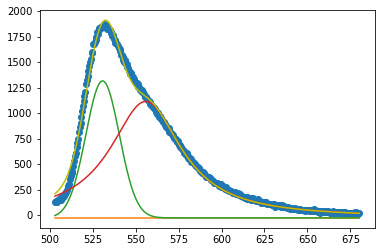

In [11]:
# plot the data
plt.plot(AniceSpectrum.get_peak()[:,0], AniceSpectrum.get_peak()[:,1],'o');

# plot the fitted baseline
plt.plot(AniceSpectrum.get_peak()[:,0], AniceSpectrum.fittedpeaks.intarray[:,0]);

# plot the fitted peaks on the baseline
plt.plot(AniceSpectrum.get_peak()[:,0], (AniceSpectrum.fittedpeaks.intarray[:,1:].T + AniceSpectrum.fittedpeaks.intarray[:,0]).T);

# plot the sum of peaks+baseline
plt.plot(AniceSpectrum.get_peak()[:,0], np.sum(AniceSpectrum.fittedpeaks.intarray, axis=1), color='y');

Many results of the fitting routine are now available via *AniceSpectrum.fitresults* for instance the final parameters:

In [12]:
with np.printoptions(precision=5, suppress = True):
        print(AniceSpectrum.fitresults.parameters)

[  -25.79361     0.      32847.67127   530.75369    23.00597 90668.58495
   555.86813    50.61942]


The results will most probably not be perfect in the first try, so go back to Step 2 and start playing with the parameters.

## Advanced Level: How to fit multiple spectra of Series

The peakfit.fitpeak() function can also be used to fit all spectra of a series for this it is applied to the SpectralSeries or TimeSeries objects:

In [13]:
pkfit.fitpeak(ts, 
              initpara, 
              fitparbool, 
              model, 
              xrange = xrange,
              lb=lowerbound, 
              ub=upperbound,
              verbose=0)

The results can be retrieved by iterating over *ts*. Here we extract the area, positions and widths of the fitted peaks:

In [14]:
fittedpeakareas=np.array([spectr.fitresults.parameters[[2,5]] for spectr in ts])

fittedpeakpositions=np.array([spectr.fitresults.parameters[[3,6]] for spectr in ts])

fittedpeakwidths=np.array([spectr.fitresults.parameters[[4,7]] for spectr in ts])

Then the results can be plotted:

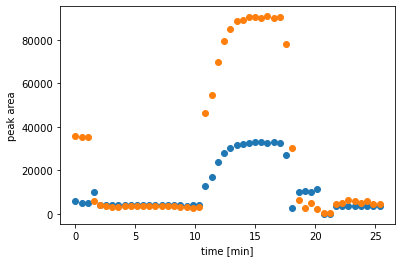

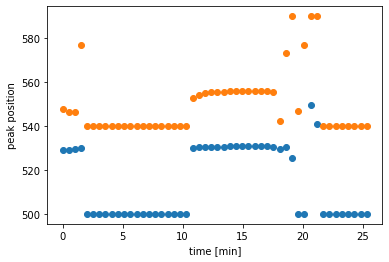

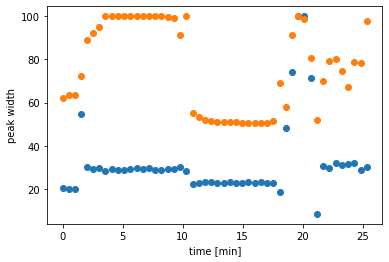

In [15]:
plt.figure()
plt.plot(ts.t_rel/60, fittedpeakareas,'o')
plt.ylabel('peak area')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts.t_rel/60, fittedpeakpositions,'o')
plt.ylabel('peak position')
plt.xlabel('time [min]');

plt.figure()
plt.plot(ts.t_rel/60, fittedpeakwidths,'o')
plt.ylabel('peak width')
plt.xlabel('time [min]');